# House-keeping

In [1]:
#Loading basic libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import math
import pandas as pd

#Loading ML libraries
from tensorflow import keras
import tensorflow as tf

## Data preparation
from tensorflow.keras.utils import to_categorical

In [2]:
# Mounting drive
from google.colab import drive
import os
if os.path.ismount('/content/drive'):
    print("Google Drive is already mounted.")
else:
    drive.mount('/content/drive')
    print("Google Drive is succesfully mounted")

Google Drive is already mounted.


In [3]:
# to work with ipynb
!pip install importnb

# Arrange directories
import sys, os

project_root = '/content/drive/MyDrive/Github/1A - Hot dog or not hot dog'
scr = os.path.join(project_root, 'scr')

os.chdir(project_root)  # main.py will be here (using this notebook for testing scripts for now)
sys.path.append(scr)    # script folder

print(os.getcwd())

/content/drive/MyDrive/Github/1A - Hot dog or not hot dog


In [4]:
# Dealing with config
import json

with open('config.json') as f:
    cfg = json.load(f)

# importing config vars (yes, i know. but it works. refactor later.)
seed = cfg["seed"]
model = cfg["model"]
validation_split = cfg["validation_split"]
train_hot_dog_path = cfg["data_paths"]["train_hot_dog"]
test_hot_dog_path = cfg["data_paths"]["test_hot_dog"]
train_not_hot_dog_path = cfg["data_paths"]["train_not_hot_dog"]
test_not_hot_dog_path = cfg["data_paths"]["test_not_hot_dog"]
img_rows = cfg["data_parameters"]["img_rows"]
img_cols = cfg["data_parameters"]["img_cols"]
num_classes = cfg["data_parameters"]["num_classes"]
channels = cfg["data_parameters"]["channels"]
class_names = cfg["data_parameters"]["class_names"]
export_dir = cfg["export"]["export_dir"]
model_name = cfg["export"]["model_name"]
optimizer = cfg["optimize"]["optimizer"]
learning_rate = cfg["optimize"]["learning_rate"]
loss = cfg["optimize"]["loss"]
metrics = cfg["optimize"]["metrics"]
epochs = cfg["optimize"]["epochs"]
batch_size = cfg["optimize"]["batch_size"]
weight_decay = cfg["optimize"]["weight_decay"]
beta_1 = cfg["optimize"]["beta_1"]
beta_2 = cfg["optimize"]["beta_2"]
epsilon = cfg["optimize"]["epsilon"]

In [5]:
# scr (use .ipynb files for now)
from importnb import Notebook
with Notebook():
    import preprocessing
    import models
    from optimizer import get_optimizer
    import export

In [6]:
# ensure replicability
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [7]:
# Show all physical devices TF can see
print("Physical devices detected:", tf.config.list_physical_devices())

# Quick check if GPU is available
print("Is built with GPU support:", tf.test.is_built_with_cuda())
print("Is GPU available to TF:", tf.config.list_physical_devices('GPU'))

# Which device ops are placed on by default
print("Default device:", tf.test.gpu_device_name())

Physical devices detected: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is built with GPU support: True
Is GPU available to TF: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default device: /device:GPU:0


<a id = "cell_Preprocessing"></a>
# 1. Data loading and preparation

In [8]:
# building train and test datasets
train_folder = [
    (train_hot_dog_path, "hot_dog"),
    (train_not_hot_dog_path, "not_hot_dog")
]

test_folder = [
    (test_hot_dog_path, "hot_dog"),
    (test_not_hot_dog_path, "not_hot_dog")
]
train_data = preprocessing.preprocess_image(train_folder,image_size= (img_rows,img_cols))
test_data = preprocessing.preprocess_image(test_folder,image_size= (img_rows,img_cols))

In [9]:
# Converting image to arrays
result = preprocessing.image_to_array(train_data,test_data)
x_train = result['x_train']
y_train = result['y_train']
x_test = result['x_test']
y_test = result['y_test']

In [10]:
# Normalize data
result = preprocessing.image_data_normalizer(x_train,x_test,scale_type="0-1")
x_train = result['x_train']
x_test = result['x_test']

In [11]:
# encoding labels
# Create a NumPy array with category strings
categories = np.array(['hot_dog','not_hot_dog'])

# Create a mapping from category strings to integers
category_map = {'hot_dog': 1, 'not_hot_dog': 0}

# Encode the categories
y_train = np.array([category_map[category] for category in y_train])
y_test = np.array([category_map[category] for category in y_test])

In [12]:
# Reshape images for processing
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

print('Train shape: x=', x_train.shape, ', y=', y_train.shape)
print('Test shape: x=', x_test.shape, ', y=', y_test.shape)

Train shape: x= (4242, 128, 128, 3) , y= (4242,)
Test shape: x= (400, 128, 128, 3) , y= (400,)


# Modellings

In [13]:
# Keras callbacks (stop if val_loss doesn't improve after 20 epochs)
from tensorflow.keras.callbacks import TensorBoard, Callback, EarlyStopping

keras_callbacks = [EarlyStopping(monitor='val_loss', patience=20, verbose=0)]

In [14]:
# Choose model
model_func = getattr(models, model)
model = model_func()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Getting optimizer
optimize = get_optimizer(cfg["optimize"])

# Compiling model
model.compile(
    optimizer=optimize,
    loss=loss,
    metrics=metrics
)

# Fitting and recording training history
history = model.fit(x_train, y_train,
      batch_size=batch_size,
      epochs=epochs,
      verbose=2,
      validation_data=(x_test, y_test),
      validation_split=validation_split,
      callbacks=keras_callbacks)

Epoch 1/100
133/133 - 16s - 118ms/step - accuracy: 0.5240 - loss: 2.0457 - val_accuracy: 0.5000 - val_loss: 1.9506
Epoch 2/100
133/133 - 15s - 116ms/step - accuracy: 0.5377 - loss: 1.7419 - val_accuracy: 0.5000 - val_loss: 1.7672
Epoch 3/100
133/133 - 10s - 76ms/step - accuracy: 0.5752 - loss: 1.6186 - val_accuracy: 0.5050 - val_loss: 1.6275
Epoch 4/100
133/133 - 10s - 78ms/step - accuracy: 0.5684 - loss: 1.5565 - val_accuracy: 0.5000 - val_loss: 1.7638
Epoch 5/100
133/133 - 10s - 75ms/step - accuracy: 0.5705 - loss: 1.4842 - val_accuracy: 0.5000 - val_loss: 1.6296
Epoch 6/100
133/133 - 10s - 77ms/step - accuracy: 0.6106 - loss: 1.4228 - val_accuracy: 0.5050 - val_loss: 1.5325
Epoch 7/100
133/133 - 10s - 77ms/step - accuracy: 0.5771 - loss: 1.4112 - val_accuracy: 0.5000 - val_loss: 1.5106
Epoch 8/100
133/133 - 10s - 76ms/step - accuracy: 0.6245 - loss: 1.3447 - val_accuracy: 0.5050 - val_loss: 1.4291
Epoch 9/100
133/133 - 10s - 78ms/step - accuracy: 0.5990 - loss: 1.3286 - val_accuracy

In [16]:
# Preliminary evaluation on training data
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', round(train_score[0], 4))
print('Train accuracy:', round(train_score[1], 4), '\n')

# Preliminary evaluation on test data
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', round(test_score[0], 4))
print('Test accuracy:', round(test_score[1], 4))

Train loss: 0.6303
Train accuracy: 0.7459 

Test loss: 1.0911
Test accuracy: 0.6025


# Evaluate performance

In [17]:
## Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [18]:
# Make predictions on the test set
y_pred = model.predict(x_test)

# Convert the predicted labels to continuous-multioutput format
y_pred = np.round(y_pred)

# Calculate the kappa score
kappa = cohen_kappa_score(y_test, y_pred)
print("The result of Kappa is :", round(kappa, 3))

# Generate the classification report
report = classification_report(y_test, y_pred, target_names = class_names)

# Print the report
print("The result of the classification report is: \n ",report)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The result of Kappa is : 0.205
The result of the classification report is: 
                precision    recall  f1-score   support

     hot_dog       0.60      0.60      0.60       200
 not_hot_dog       0.60      0.60      0.60       200

    accuracy                           0.60       400
   macro avg       0.60      0.60      0.60       400
weighted avg       0.60      0.60      0.60       400



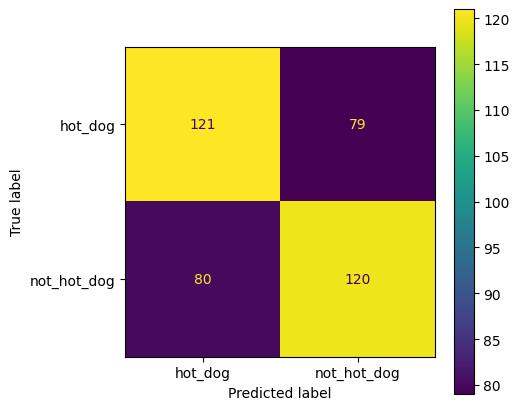

In [19]:
#Generating confusion matrix
cm = confusion_matrix(
    y_test,
    y_pred)

# Create a ConfusionMatrixDisplay object
display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names)

# Create a figure with a larger size
fig = plt.figure(figsize=(5, 5))

# Create a subplot within the figure
ax = fig.subplots()

# Plot the confusion matrix as a heatmap
display.plot(ax=ax)

# Show the plot
plt.show()

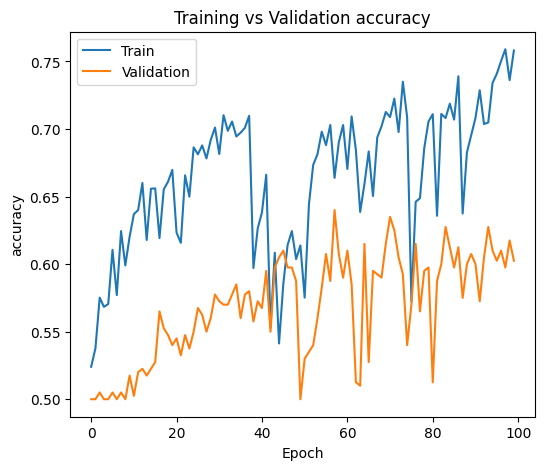

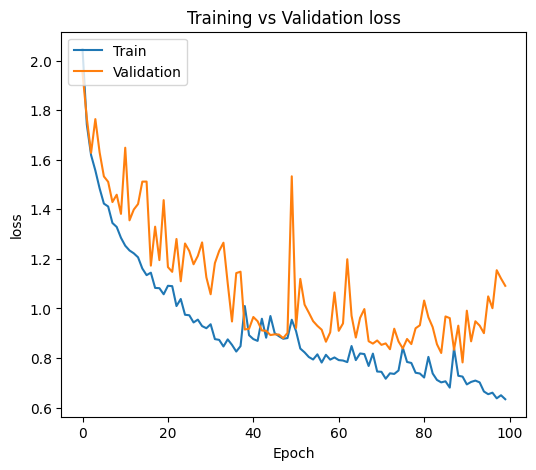

In [20]:
#Plotting learning history
#Platform prepping
def plot_hist(h, xsize=6, ysize=5):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]

    # Get training and validation keys
    ks = list(h.keys())
    n2 = math.floor(len(ks)/2)
    train_keys = ks[0:n2]
    valid_keys = ks[n2:2*n2]

    # summarize history for different metrics
    for i in range(n2):
        plt.plot(h[train_keys[i]])
        plt.plot(h[valid_keys[i]])
        plt.title('Training vs Validation '+train_keys[i])
        plt.ylabel(train_keys[i])
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.draw()
        plt.show()

    return

#Execute
plot_hist(pd.DataFrame(history.history))

# Export model and result

In [21]:
# Some final note about this version of the model before exporting. will also be exported into a note.txt file
note = ""

In [22]:
# only save model trained on full train set (some test runs are done on "small" dataset to check scripts)
export.save_model_and_metrics(model=model,
                              history=history,
                              x_test=x_test,
                              y_test=y_test,
                              export_dir=export_dir,
                              model_name=model_name,
                              config=cfg,
                              note=note)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Saved model, metrics and config to /content/drive/MyDrive/Github/1A - Hot dog or not hot dog/models/hot_dog_or_not_hot_dog_v001_2025-09-14_15-47
